# Book Recommendation LLM Agent
## Using Book-Crossing Dataset + Open Library API

This notebook builds a conversational book recommendation agent that:
- Uses collaborative filtering on the Book-Crossing dataset
- Enriches recommendations with Open Library API data
- Provides an LLM-powered natural language interface

### Setup Steps:
1. Install dependencies
2. Download and load Kaggle dataset
3. Build recommendation models
4. Integrate Open Library API
5. Create LLM agent interface

## 1. Install Dependencies and Setup

In [1]:
# Install NumPy 1.x before importing anything
!pip uninstall numpy -y
!pip install 'numpy<2.0' --no-cache-dir
print("NumPy 1.x installed")

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 49.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,

NumPy 1.x installed


In [1]:
# Now install everything else
!pip install kaggle pandas scikit-learn matplotlib seaborn requests -q
!pip install anthropic openai python-dotenv -q
!pip install scikit-surprise -q

print("All packages installed!")

All packages installed!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print(f"All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All imports successful!
NumPy version: 1.26.4
Pandas version: 2.2.2


## 2. Download Book-Crossing Dataset from Kaggle

In [7]:
import json
import os
from google.colab import userdata

# Get Kaggle credentials from Colab secrets/environment variables
try:
    # Option 1: If using Colab Secrets (recommended)
    KAGGLE_USERNAME = userdata.get('KAGGLE_USERNAME')
    KAGGLE_KEY = userdata.get('KAGGLE_KEY')
except:
    # Option 2: If using environment variables
    KAGGLE_USERNAME = os.environ.get('KAGGLE_USERNAME')
    KAGGLE_KEY = os.environ.get('KAGGLE_KEY')

# Create kaggle directory and credentials file
!mkdir -p ~/.kaggle

with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)

!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle credentials configured!")

Kaggle credentials configured!


In [8]:
# Download the Book-Crossing dataset
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip -q book-recommendation-dataset.zip -d book_data
!ls book_data

print("\nDataset downloaded and extracted!")

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
  0% 0.00/24.3M [00:00<?, ?B/s]
100% 24.3M/24.3M [00:00<00:00, 1.49GB/s]
Books.csv	DeepRec.png  recsys_taxonomy2.png
classicRec.png	Ratings.csv  Users.csv

Dataset downloaded and extracted!


## 3. Load and Explore Data

In [9]:
# Load the three main files
books = pd.read_csv('book_data/Books.csv', low_memory=False, encoding='latin-1')
ratings = pd.read_csv('book_data/Ratings.csv', encoding='latin-1')
users = pd.read_csv('book_data/Users.csv', encoding='latin-1')

print("Books shape:", books.shape)
print("Ratings shape:", ratings.shape)
print("Users shape:", users.shape)

print("\n=== Books Sample ===")
print(books.head())

print("\n=== Ratings Sample ===")
print(ratings.head())

print("\n=== Books Info ===")
print(books.info())

Books shape: (271360, 8)
Ratings shape: (1149780, 3)
Users shape: (278858, 3)

=== Books Sample ===
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                        

## 4. Data Preprocessing

Missing values in books:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

After removing 0 ratings: 433671 ratings

=== Rating Statistics ===
count    433671.000000
mean          7.601066
std           1.843798
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book-Rating, dtype: float64


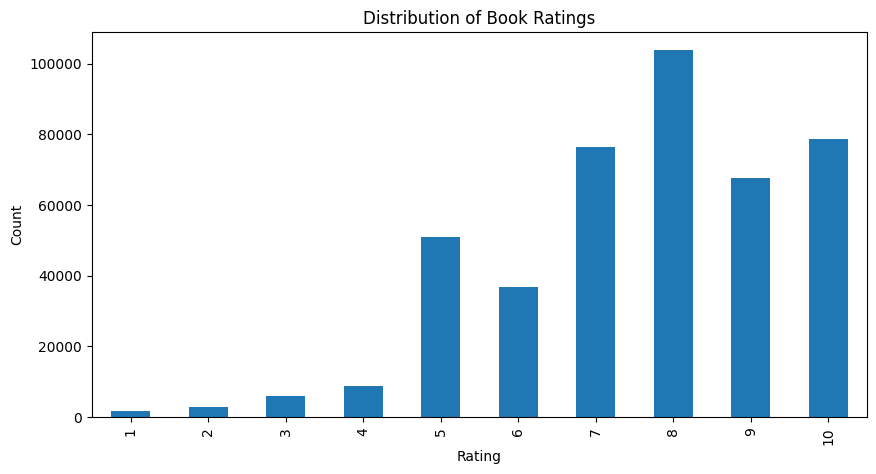

In [10]:
# Clean column names
books.columns = books.columns.str.strip()
ratings.columns = ratings.columns.str.strip()

# Check for missing values
print("Missing values in books:")
print(books.isnull().sum())

# Fill missing authors and publishers
books['Book-Author'].fillna('Unknown', inplace=True)
books['Publisher'].fillna('Unknown', inplace=True)

# Remove ratings of 0 (implicit ratings that don't provide much value)
ratings = ratings[ratings['Book-Rating'] > 0]

print(f"\nAfter removing 0 ratings: {ratings.shape[0]} ratings")

# Get rating statistics
print("\n=== Rating Statistics ===")
print(ratings['Book-Rating'].describe())

# Check rating distribution
plt.figure(figsize=(10, 5))
ratings['Book-Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [13]:
# Filter to books and users with sufficient ratings for better recommendations
# Keep books with at least 10 ratings
book_rating_counts = ratings.groupby('ISBN')['Book-Rating'].count()
popular_books = book_rating_counts[book_rating_counts >= 10].index

# Keep users who have rated at least 10 books
user_rating_counts = ratings.groupby('User-ID')['Book-Rating'].count()
active_users = user_rating_counts[user_rating_counts >= 10].index

# Filter ratings
filtered_ratings = ratings[
    (ratings['ISBN'].isin(popular_books)) &
    (ratings['User-ID'].isin(active_users))
]

print(f"Original ratings: {len(ratings)}")
print(f"Filtered ratings: {len(filtered_ratings)}")
print(f"Unique books: {filtered_ratings['ISBN'].nunique()}")
print(f"Unique users: {filtered_ratings['User-ID'].nunique()}")

Original ratings: 433671
Filtered ratings: 90556
Unique books: 5640
Unique users: 6837


## 5. Build Collaborative Filtering Model

In [15]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(filtered_ratings[['User-ID', 'ISBN', 'Book-Rating']], reader)

# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

print("Training collaborative filtering model...")

# Train SVD model (Matrix Factorization)
svd_model = SVD(n_factors=50, n_epochs=20, random_state=42)
svd_model.fit(trainset)

print("SVD Model trained!")

# Train KNN model (Item-based collaborative filtering)
knn_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': False})
knn_model.fit(trainset)

print("KNN Model trained!")

Training collaborative filtering model...
SVD Model trained!
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNN Model trained!


In [16]:
# Evaluate models
from surprise import accuracy

svd_predictions = svd_model.test(testset)
knn_predictions = knn_model.test(testset)

print("=== Model Performance ===")
print("\nSVD Model:")
svd_rmse = accuracy.rmse(svd_predictions)

print("\nKNN Model:")
knn_rmse = accuracy.rmse(knn_predictions)

=== Model Performance ===

SVD Model:
RMSE: 1.5571

KNN Model:
RMSE: 1.7242


## 6. Build Content-Based Filtering Model

In [17]:
# Create content features from book metadata
# Combine author and title for content-based filtering
books['content'] = books['Book-Title'].fillna('') + ' ' + books['Book-Author'].fillna('')

# Get books that are in our filtered dataset
popular_books_df = books[books['ISBN'].isin(popular_books)].copy()

# Create TF-IDF matrix
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(popular_books_df['content'])

# Calculate cosine similarity
content_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create ISBN to index mapping
isbn_to_idx = {isbn: idx for idx, isbn in enumerate(popular_books_df['ISBN'])}
idx_to_isbn = {idx: isbn for isbn, idx in isbn_to_idx.items()}

print(f"Content-based model built for {len(popular_books_df)} books")

Content-based model built for 5444 books


## 7. Open Library API Integration

In [18]:
class OpenLibraryAPI:
    """Wrapper for Open Library API to fetch book information"""

    BASE_URL = "https://openlibrary.org"

    @staticmethod
    def search_books(query, limit=10):
        """Search for books by title, author, or keyword"""
        url = f"{OpenLibraryAPI.BASE_URL}/search.json"
        params = {'q': query, 'limit': limit}

        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Error searching books: {e}")
            return None

    @staticmethod
    def get_book_by_isbn(isbn):
        """Get detailed book information by ISBN"""
        url = f"{OpenLibraryAPI.BASE_URL}/api/books"
        params = {
            'bibkeys': f'ISBN:{isbn}',
            'format': 'json',
            'jscmd': 'data'
        }

        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            return data.get(f'ISBN:{isbn}', None)
        except Exception as e:
            print(f"Error fetching book by ISBN: {e}")
            return None

    @staticmethod
    def get_book_details(work_id):
        """Get work details from Open Library"""
        url = f"{OpenLibraryAPI.BASE_URL}/works/{work_id}.json"

        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Error fetching work details: {e}")
            return None

    @staticmethod
    def search_by_genre(genre, limit=20):
        """Search books by genre/subject"""
        url = f"{OpenLibraryAPI.BASE_URL}/search.json"
        params = {'subject': genre, 'limit': limit}

        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Error searching by genre: {e}")
            return None

# Test the API
print("Testing Open Library API...")
test_result = OpenLibraryAPI.search_books("Harry Potter", limit=3)
if test_result and 'docs' in test_result:
    print(f"API working! Found {test_result['numFound']} books")
    print("\nSample book:")
    if test_result['docs']:
        sample = test_result['docs'][0]
        print(f"Title: {sample.get('title', 'N/A')}")
        print(f"Author: {sample.get('author_name', ['N/A'])[0] if sample.get('author_name') else 'N/A'}")

Testing Open Library API...
API working! Found 3828 books

Sample book:
Title: Harry Potter and the Philosopher's Stone
Author: J. K. Rowling


## 8. Build Recommendation Engine

In [19]:
class BookRecommendationEngine:
    """Hybrid recommendation engine combining collaborative and content-based filtering"""

    def __init__(self, books_df, ratings_df, svd_model, knn_model,
                 content_similarity, isbn_to_idx, idx_to_isbn):
        self.books = books_df
        self.ratings = ratings_df
        self.svd_model = svd_model
        self.knn_model = knn_model
        self.content_similarity = content_similarity
        self.isbn_to_idx = isbn_to_idx
        self.idx_to_isbn = idx_to_isbn
        self.ol_api = OpenLibraryAPI()

    def get_book_info(self, isbn):
        """Get book information from local dataset"""
        book = self.books[self.books['ISBN'] == isbn]
        if len(book) > 0:
            return book.iloc[0].to_dict()
        return None

    def recommend_by_title(self, book_title, n=10):
        """Recommend books similar to a given title (content-based)"""
        # Find the book in our dataset
        matching_books = self.books[
            self.books['Book-Title'].str.contains(book_title, case=False, na=False)
        ]

        if len(matching_books) == 0:
            return None, "Book not found in dataset"

        # Use the first match
        book = matching_books.iloc[0]
        isbn = book['ISBN']

        # Check if book is in our similarity matrix
        if isbn not in self.isbn_to_idx:
            return None, "Book not in recommendation database"

        # Get similar books using content similarity
        idx = self.isbn_to_idx[isbn]
        similarity_scores = list(enumerate(self.content_similarity[idx]))
        similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
        similarity_scores = similarity_scores[1:n+1]  # Exclude the book itself

        recommendations = []
        for idx, score in similarity_scores:
            rec_isbn = self.idx_to_isbn[idx]
            book_info = self.get_book_info(rec_isbn)
            if book_info:
                book_info['similarity_score'] = score
                recommendations.append(book_info)

        return recommendations, None

    def recommend_by_genre(self, genre, n=10):
        """Recommend books by genre using Open Library API"""
        result = self.ol_api.search_by_genre(genre, limit=n*2)

        if not result or 'docs' not in result:
            return None, "Could not fetch genre recommendations"

        recommendations = []
        for doc in result['docs'][:n]:
            rec = {
                'title': doc.get('title', 'N/A'),
                'author': doc.get('author_name', ['N/A'])[0] if doc.get('author_name') else 'N/A',
                'first_publish_year': doc.get('first_publish_year', 'N/A'),
                'isbn': doc.get('isbn', ['N/A'])[0] if doc.get('isbn') else 'N/A',
                'subjects': doc.get('subject', [])[:5] if doc.get('subject') else []
            }
            recommendations.append(rec)

        return recommendations, None

    def recommend_popular(self, n=10):
        """Recommend most popular books based on ratings"""
        # Calculate average rating and count for each book
        book_stats = self.ratings.groupby('ISBN').agg({
            'Book-Rating': ['mean', 'count']
        }).reset_index()
        book_stats.columns = ['ISBN', 'avg_rating', 'rating_count']

        # Calculate weighted rating (IMDB formula)
        C = book_stats['avg_rating'].mean()
        m = book_stats['rating_count'].quantile(0.75)

        qualified = book_stats[book_stats['rating_count'] >= m]

        def weighted_rating(x):
            v = x['rating_count']
            R = x['avg_rating']
            return (v/(v+m) * R) + (m/(m+v) * C)

        qualified['score'] = qualified.apply(weighted_rating, axis=1)
        qualified = qualified.sort_values('score', ascending=False)

        # Get top N books
        top_isbns = qualified.head(n)['ISBN'].values

        recommendations = []
        for isbn in top_isbns:
            book_info = self.get_book_info(isbn)
            if book_info:
                stats = qualified[qualified['ISBN'] == isbn].iloc[0]
                book_info['avg_rating'] = round(stats['avg_rating'], 2)
                book_info['rating_count'] = int(stats['rating_count'])
                book_info['weighted_score'] = round(stats['score'], 2)
                recommendations.append(book_info)

        return recommendations, None

    def search_books(self, query, n=10):
        """Search for books using Open Library API"""
        result = self.ol_api.search_books(query, limit=n)

        if not result or 'docs' not in result:
            return None, "Could not fetch search results"

        recommendations = []
        for doc in result['docs'][:n]:
            rec = {
                'title': doc.get('title', 'N/A'),
                'author': doc.get('author_name', ['N/A'])[0] if doc.get('author_name') else 'N/A',
                'first_publish_year': doc.get('first_publish_year', 'N/A'),
                'isbn': doc.get('isbn', ['N/A'])[0] if doc.get('isbn') else 'N/A',
            }
            recommendations.append(rec)

        return recommendations, None

# Initialize the recommendation engine
rec_engine = BookRecommendationEngine(
    books_df=popular_books_df,
    ratings_df=filtered_ratings,
    svd_model=svd_model,
    knn_model=knn_model,
    content_similarity=content_similarity,
    isbn_to_idx=isbn_to_idx,
    idx_to_isbn=idx_to_isbn
)

print("Recommendation engine initialized!")

Recommendation engine initialized!


## 9. Test Basic Recommendations

In [20]:
# Test popular books
print("=== Top 5 Popular Books ===")
popular, _ = rec_engine.recommend_popular(n=5)
for i, book in enumerate(popular, 1):
    print(f"{i}. {book['Book-Title']} by {book['Book-Author']}")
    print(f"   Avg Rating: {book['avg_rating']}, Count: {book['rating_count']}")
    print()

=== Top 5 Popular Books ===
1. Harry Potter and the Goblet of Fire (Book 4) by J. K. Rowling
   Avg Rating: 9.3, Count: 105

2. The Return of the King (The Lord of the Rings, Part 3) by J.R.R. TOLKIEN
   Avg Rating: 9.46, Count: 54

3. Harry Potter and the Prisoner of Azkaban (Book 3) by J. K. Rowling
   Avg Rating: 9.2, Count: 110

4. The Two Towers (The Lord of the Rings, Part 2) by J.R.R. TOLKIEN
   Avg Rating: 9.31, Count: 58

5. Harry Potter and the Chamber of Secrets Postcard Book by J. K. Rowling
   Avg Rating: 9.86, Count: 22



In [21]:
# Test genre-based recommendations
print("=== Science Fiction Recommendations ===")
sci_fi, _ = rec_engine.recommend_by_genre('science fiction', n=5)
if sci_fi:
    for i, book in enumerate(sci_fi, 1):
        print(f"{i}. {book['title']} by {book['author']}")
        print(f"   Published: {book['first_publish_year']}")
        print()

=== Science Fiction Recommendations ===
1. A Modern Utopia by H. G. Wells
   Published: 1900

2. On the Beach by Nevil Shute
   Published: 1957

3. The food of the gods and how it came to earth by H. G. Wells
   Published: 1900

4. 2001 by Arthur C. Clarke
   Published: 1968

5. The Martian Chronicles by Ray Bradbury
   Published: 1950



## 10. Build LLM Agent Interface

In [40]:
# Set up your API key here
from google.colab import userdata

LLM_PROVIDER = None

# Option 1: Hugging Face
try:
    from huggingface_hub import InferenceClient
    HF_TOKEN = userdata.get('HUGGINGFACE_TOKEN')

    # Initialize client
    hf_client = InferenceClient(token=HF_TOKEN)

    # Use chat interface instead of text generation
    test_response = hf_client.chat_completion(
        messages=[{"role": "user", "content": "Hello"}],
        model="mistralai/Mistral-7B-Instruct-v0.2",
        max_tokens=10
    )

    LLM_PROVIDER = 'huggingface'
    print("Using Hugging Face (Mistral-7B-Instruct)")

except Exception as e:
    print(f"Hugging Face not available: {e}")

    # Try alternative models
    try:
        from huggingface_hub import InferenceClient
        HF_TOKEN = userdata.get('HF_TOKEN')
        hf_client = InferenceClient(token=HF_TOKEN)

        # Try meta-llama model
        test_response = hf_client.chat_completion(
            messages=[{"role": "user", "content": "Hello"}],
            model="meta-llama/Meta-Llama-3-8B-Instruct",
            max_tokens=10
        )

        LLM_PROVIDER = 'huggingface'
        print("Using Hugging Face (Llama-3-8B-Instruct)")
    except Exception as e2:
        print(f"Llama also failed: {e2}")

# No provider configured
if not LLM_PROVIDER:
    print("\nNo LLM provider configured!")

Using Hugging Face (Mistral-7B-Instruct)


In [43]:
# Install packages for enrichment
!pip install transformers torch sentence-transformers scikit-learn -q

print("All enrichment packages installed!")

All enrichment packages installed!


In [44]:
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("STARTING COMPLETE BOOK ENRICHMENT PIPELINE")

# 1. SENTIMENT ANALYSIS (Based on ratings distribution)

print("\n[1/5] Running Sentiment Analysis...")

def analyze_sentiment(ratings_df):
    """Analyze sentiment from rating patterns"""
    book_stats = ratings_df.groupby('ISBN').agg({
        'Book-Rating': ['mean', 'count', 'std']
    }).reset_index()
    book_stats.columns = ['ISBN', 'avg_rating', 'rating_count', 'rating_std']

    def calculate_sentiment_score(row):
        """Convert ratings to sentiment score (0-1)"""
        avg = row['avg_rating']
        std = row['rating_std'] if pd.notna(row['rating_std']) else 0

        # Normalize rating (1-10 to 0-1)
        normalized_rating = (avg - 1) / 9

        # Penalize high variance (controversial books)
        consistency_score = 1 - min(std / 5, 1)

        # Combined sentiment score
        sentiment_score = (normalized_rating * 0.7) + (consistency_score * 0.3)
        return round(sentiment_score, 3)

    def categorize_sentiment(score):
        """Categorize sentiment score"""
        if score >= 0.8:
            return 'Very Positive'
        elif score >= 0.6:
            return 'Positive'
        elif score >= 0.4:
            return 'Mixed'
        elif score >= 0.2:
            return 'Negative'
        else:
            return 'Very Negative'

    book_stats['sentiment_score'] = book_stats.apply(calculate_sentiment_score, axis=1)
    book_stats['sentiment_category'] = book_stats['sentiment_score'].apply(categorize_sentiment)

    return book_stats

sentiment_data = analyze_sentiment(filtered_ratings)
print(f"   Analyzed {len(sentiment_data)} books")
print(f"   Distribution: {dict(sentiment_data['sentiment_category'].value_counts())}")

# 2. TOPIC MODELING (Extract themes from titles & authors)

print("\n[2/5] Running Topic Modeling...")

def extract_topics(books_df, n_topics=20):
    """Extract topics using LDA"""
    # Create document corpus
    books_df = books_df.copy()
    books_df['text'] = books_df['Book-Title'].fillna('') + ' ' + books_df['Book-Author'].fillna('')

    # Vectorize
    vectorizer = CountVectorizer(
        max_features=1000,
        stop_words='english',
        max_df=0.8,
        min_df=5
    )
    doc_term_matrix = vectorizer.fit_transform(books_df['text'])

    # LDA topic modeling
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20,
        n_jobs=-1
    )
    lda.fit(doc_term_matrix)

    # Get dominant topic for each book
    topic_distributions = lda.transform(doc_term_matrix)
    dominant_topics = np.argmax(topic_distributions, axis=1)
    topic_strengths = np.max(topic_distributions, axis=1)

    # Create topic labels (top 3 words per topic)
    feature_names = vectorizer.get_feature_names_out()
    topic_labels = []
    topic_words_list = []

    for topic_idx, topic in enumerate(lda.components_):
        top_word_indices = topic.argsort()[-5:][::-1]
        top_words = [feature_names[i] for i in top_word_indices]
        topic_words_list.append(top_words)
        topic_labels.append('_'.join(top_words[:3]))

    books_df['dominant_topic'] = dominant_topics
    books_df['topic_label'] = [topic_labels[t] for t in dominant_topics]
    books_df['topic_strength'] = topic_strengths

    return books_df, lda, vectorizer, topic_labels, topic_words_list

books_with_topics, lda_model, vectorizer, topic_labels, topic_words = extract_topics(
    popular_books_df.copy()
)
print(f"   Extracted {len(topic_labels)} topics")
print(f"   Sample topics: {topic_labels[:3]}")

# 3. BOOK EMBEDDINGS (Semantic representations for similarity)

print("\n[3/5] Creating Book Embeddings (this may take 5-10 minutes)...")

def create_embeddings(books_df, batch_size=32):
    """Create semantic embeddings for books"""
    print("   Loading embedding model...")
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        print("   Using GPU for embeddings")

    # Create text for embedding
    texts = (
        books_df['Book-Title'].fillna('') + ' by ' +
        books_df['Book-Author'].fillna('')
    ).tolist()

    embeddings = []
    print(f"   Processing {len(texts)} books in batches of {batch_size}...")

    for i in tqdm(range(0, len(texts), batch_size), desc="   Encoding"):
        batch_texts = texts[i:i+batch_size]

        # Tokenize and encode
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=128
        )

        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # Mean pooling
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu().numpy())

    embeddings = np.vstack(embeddings)
    print(f"   Created embeddings with shape: {embeddings.shape}")

    return embeddings

embeddings = create_embeddings(books_with_topics)

# 4. READING LEVEL ESTIMATION

print("\n[4/5] Estimating Reading Levels...")

def estimate_reading_level(books_df):
    """Estimate reading difficulty from title complexity"""
    def get_reading_level(title):
        if pd.isna(title):
            return 'Unknown'

        words = title.split()
        if not words:
            return 'Unknown'

        avg_word_len = np.mean([len(w) for w in words])
        word_count = len(words)

        # Combined heuristic
        if avg_word_len < 5 and word_count < 5:
            return 'Easy'
        elif avg_word_len < 7 and word_count < 8:
            return 'Intermediate'
        else:
            return 'Advanced'

    books_df['reading_level'] = books_df['Book-Title'].apply(get_reading_level)
    return books_df

books_with_topics = estimate_reading_level(books_with_topics)
print(f"   Reading levels: {dict(books_with_topics['reading_level'].value_counts())}")

# 5. GENRE CLASSIFICATION (Enhanced keyword-based)

print("\n[5/5] Classifying Genres...")

def classify_genres(books_df):
    """Classify books into genres using keyword matching"""
    genre_keywords = {
        'Fantasy': ['magic', 'dragon', 'wizard', 'fantasy', 'quest', 'sword', 'kingdom', 'sorcerer'],
        'Science Fiction': ['space', 'future', 'robot', 'alien', 'time', 'star', 'galaxy', 'mars'],
        'Mystery': ['mystery', 'detective', 'murder', 'crime', 'investigation', 'clue', 'suspect'],
        'Romance': ['love', 'heart', 'romance', 'bride', 'wedding', 'passion', 'kiss'],
        'Thriller': ['thriller', 'suspense', 'danger', 'chase', 'escape', 'spy', 'conspiracy'],
        'Horror': ['horror', 'ghost', 'dark', 'fear', 'terror', 'nightmare', 'haunted'],
        'Historical': ['history', 'war', 'century', 'historical', 'ancient', 'era', 'civil war'],
        'Biography': ['life', 'biography', 'memoir', 'story of', 'autobiography', 'true story'],
        'Self-Help': ['guide', 'how to', 'success', 'improve', 'better', 'yourself', 'tips'],
        'Adventure': ['adventure', 'journey', 'expedition', 'treasure', 'island', 'explorer'],
    }

    def detect_genre(title):
        if pd.isna(title):
            return 'Fiction'

        title_lower = title.lower()
        detected = []

        for genre, keywords in genre_keywords.items():
            if any(keyword in title_lower for keyword in keywords):
                detected.append(genre)

        return detected[0] if detected else 'Fiction'

    books_df['detected_genre'] = books_df['Book-Title'].apply(detect_genre)
    return books_df

books_with_topics = classify_genres(books_with_topics)
print(f"   Genre distribution: {dict(books_with_topics['detected_genre'].value_counts().head())}")

# MERGE ALL ENRICHMENTS

print("\n[FINAL] 🔗 Merging all enrichments...")

fully_enriched = books_with_topics.merge(sentiment_data, on='ISBN', how='left')

# Add recommendation confidence score
def calculate_confidence(row):
    """Calculate overall recommendation confidence"""
    rating_factor = row['avg_rating'] / 10 if pd.notna(row['avg_rating']) else 0.5
    count_factor = min(row['rating_count'] / 100, 1) if pd.notna(row['rating_count']) else 0.1
    sentiment_factor = row['sentiment_score'] if pd.notna(row['sentiment_score']) else 0.5
    topic_factor = row['topic_strength'] if pd.notna(row['topic_strength']) else 0.5

    confidence = (
        rating_factor * 0.35 +
        count_factor * 0.25 +
        sentiment_factor * 0.25 +
        topic_factor * 0.15
    )
    return round(confidence, 3)

fully_enriched['recommendation_confidence'] = fully_enriched.apply(calculate_confidence, axis=1)

# Add popularity score
fully_enriched['popularity_score'] = (
    fully_enriched['rating_count'].fillna(0) /
    fully_enriched['rating_count'].max()
).round(3)

print("ENRICHMENT COMPLETE!")
print(f"\nEnriched {len(fully_enriched)} books with:")
print(f"   ✓ Sentiment Analysis (score + category)")
print(f"   ✓ Topic Modeling ({len(topic_labels)} topics)")
print(f"   ✓ Semantic Embeddings ({embeddings.shape[1]}D vectors)")
print(f"   ✓ Reading Levels (Easy/Intermediate/Advanced)")
print(f"   ✓ Genre Classification (10 genres)")
print(f"   ✓ Recommendation Confidence Scores")
print(f"   ✓ Popularity Scores")

# Display sample
print("\nSample of enriched data:")
sample_cols = [
    'Book-Title', 'Book-Author', 'detected_genre', 'reading_level',
    'sentiment_score', 'sentiment_category', 'topic_label',
    'recommendation_confidence', 'popularity_score'
]
print(fully_enriched[sample_cols].head(10).to_string())

STARTING COMPLETE BOOK ENRICHMENT PIPELINE

[1/5] Running Sentiment Analysis...
   Analyzed 5640 books
   Distribution: {'Positive': 4471, 'Very Positive': 934, 'Mixed': 232, 'Negative': 3}

[2/5] Running Topic Modeling...
   Extracted 20 topics
   Sample topics: ['stephen_king_tom', 'jonathan_jane_adventures', 'book_anne_club']

[3/5] Creating Book Embeddings (this may take 5-10 minutes)...
   Loading embedding model...


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

   Using GPU for embeddings
   Processing 5444 books in batches of 32...


   Encoding: 100%|██████████| 171/171 [00:02<00:00, 78.68it/s] 


   Created embeddings with shape: (5444, 384)

[4/5] Estimating Reading Levels...
   Reading levels: {'Intermediate': 2364, 'Advanced': 1900, 'Easy': 1180}

[5/5] Classifying Genres...
   Genre distribution: {'Fiction': 4339, 'Romance': 221, 'Science Fiction': 152, 'Biography': 149, 'Historical': 137}

[FINAL] 🔗 Merging all enrichments...
ENRICHMENT COMPLETE!

Enriched 5444 books with:
   ✓ Sentiment Analysis (score + category)
   ✓ Topic Modeling (20 topics)
   ✓ Semantic Embeddings (384D vectors)
   ✓ Reading Levels (Easy/Intermediate/Advanced)
   ✓ Genre Classification (10 genres)
   ✓ Recommendation Confidence Scores
   ✓ Popularity Scores

Sample of enriched data:
                                                                                      Book-Title        Book-Author   detected_genre reading_level  sentiment_score sentiment_category               topic_label  recommendation_confidence  popularity_score
0                                                                   

In [45]:
import json
import os
from datetime import datetime

print("SAVING ENRICHED DATASET")

# Create output directory
os.makedirs('enriched_data', exist_ok=True)

# 1. Save embeddings (numpy format - most efficient)

print("\n[1/5] Saving embeddings...")
np.save('enriched_data/book_embeddings.npy', embeddings)
print(f"   Saved book_embeddings.npy ({embeddings.shape})")

# 2. Save main enriched CSV (without embeddings - too large)

print("\n[2/5] Saving enriched books CSV...")
enriched_for_csv = fully_enriched[[
    'ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
    'avg_rating', 'rating_count', 'rating_std',
    'sentiment_score', 'sentiment_category',
    'dominant_topic', 'topic_label', 'topic_strength',
    'reading_level', 'detected_genre',
    'recommendation_confidence', 'popularity_score'
]].copy()

enriched_for_csv.to_csv('enriched_data/fully_enriched_books.csv', index=False)
print(f"   Saved fully_enriched_books.csv ({len(enriched_for_csv)} books)")

# 3. Save topic modeling artifacts

print("\n[3/5] Saving topic model...")

topic_info = {
    'num_topics': len(topic_labels),
    'topic_labels': topic_labels,
    'topic_keywords': topic_words
}

with open('enriched_data/topic_model_info.json', 'w') as f:
    json.dump(topic_info, f, indent=2)

print(f"   Saved topic_model_info.json ({len(topic_labels)} topics)")

# 4. Save ISBN mappings for embeddings

print("\n[4/5] Saving ISBN mappings...")

isbn_list = fully_enriched['ISBN'].tolist()
isbn_mapping = {
    'isbn_list': isbn_list,
    'num_books': len(isbn_list)
}

with open('enriched_data/isbn_to_embedding_mapping.json', 'w') as f:
    json.dump(isbn_mapping, f)

print(f"   Saved isbn_to_embedding_mapping.json ({len(isbn_list)} mappings)")

# 5. Save metadata and statistics

print("\n[5/5] Saving metadata...")

metadata = {
    'creation_date': datetime.now().isoformat(),
    'dataset_info': {
        'num_books': len(fully_enriched),
        'num_ratings': len(filtered_ratings),
        'unique_users': filtered_ratings['User-ID'].nunique(),
        'avg_rating': float(fully_enriched['avg_rating'].mean()),
        'avg_sentiment': float(fully_enriched['sentiment_score'].mean())
    },
    'enrichment_features': {
        'sentiment_analysis': {
            'method': 'rating-based',
            'categories': ['Very Positive', 'Positive', 'Mixed', 'Negative', 'Very Negative']
        },
        'topic_modeling': {
            'method': 'LDA',
            'num_topics': len(topic_labels),
            'sample_topics': topic_labels[:5]
        },
        'embeddings': {
            'model': 'sentence-transformers/all-MiniLM-L6-v2',
            'dimension': int(embeddings.shape[1]),
            'total_books': int(embeddings.shape[0])
        },
        'reading_levels': ['Easy', 'Intermediate', 'Advanced', 'Unknown'],
        'genres': list(fully_enriched['detected_genre'].unique())
    },
    'statistics': {
        'sentiment_distribution': dict(fully_enriched['sentiment_category'].value_counts().to_dict()),
        'genre_distribution': dict(fully_enriched['detected_genre'].value_counts().head(10).to_dict()),
        'reading_level_distribution': dict(fully_enriched['reading_level'].value_counts().to_dict())
    },
    'file_structure': {
        'fully_enriched_books.csv': 'Main enriched book data',
        'book_embeddings.npy': 'Semantic embeddings (numpy array)',
        'topic_model_info.json': 'Topic modeling details',
        'isbn_to_embedding_mapping.json': 'ISBN to embedding index mapping',
        'enrichment_metadata.json': 'This file - dataset documentation'
    }
}

with open('enriched_data/enrichment_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"   Saved enrichment_metadata.json")

# Create zip file for easy download

print("\n[PACKAGING] Creating zip archive...")
!cd enriched_data && zip -r ../enriched_book_dataset.zip . -q

print("ALL FILES SAVED SUCCESSFULLY!")

print("\nSaved files:")
print("   enriched_data/")
print("   ├── fully_enriched_books.csv")
print("   ├── book_embeddings.npy")
print("   ├── topic_model_info.json")
print("   ├── isbn_to_embedding_mapping.json")
print("   └── enrichment_metadata.json")


# Display file sizes
import os
def get_size(path):
    return os.path.getsize(path) / (1024 * 1024)  # MB

print("\nFile sizes:")
files = [
    'enriched_data/fully_enriched_books.csv',
    'enriched_data/book_embeddings.npy',
    'enriched_book_dataset.zip'
]
for f in files:
    if os.path.exists(f):
        print(f"   {f}: {get_size(f):.2f} MB")

SAVING ENRICHED DATASET

[1/5] Saving embeddings...
   Saved book_embeddings.npy ((5444, 384))

[2/5] Saving enriched books CSV...
   Saved fully_enriched_books.csv (5444 books)

[3/5] Saving topic model...
   Saved topic_model_info.json (20 topics)

[4/5] Saving ISBN mappings...
   Saved isbn_to_embedding_mapping.json (5444 mappings)

[5/5] Saving metadata...
   Saved enrichment_metadata.json

[PACKAGING] Creating zip archive...
ALL FILES SAVED SUCCESSFULLY!

Saved files:
   enriched_data/
   ├── fully_enriched_books.csv
   ├── book_embeddings.npy
   ├── topic_model_info.json
   ├── isbn_to_embedding_mapping.json
   └── enrichment_metadata.json

File sizes:
   enriched_data/fully_enriched_books.csv: 1.03 MB
   enriched_data/book_embeddings.npy: 7.97 MB
   enriched_book_dataset.zip: 7.75 MB


In [51]:
from sklearn.metrics.pairwise import cosine_similarity

class UltraEnhancedRecommendationEngine(BookRecommendationEngine):
    """Ultra-enhanced recommendation engine with all enrichments"""

    def __init__(self, books_df, ratings_df, svd_model, knn_model,
                 content_similarity, isbn_to_idx, idx_to_isbn, enriched_df, embeddings):
        # Call parent init with ALL required arguments
        super().__init__(books_df, ratings_df, svd_model, knn_model,
                        content_similarity, isbn_to_idx, idx_to_isbn)

        # Add our enrichment data
        self.enriched_books = enriched_df
        self.embeddings = embeddings

        # Create ISBN to embedding index mapping
        self.isbn_list = enriched_df['ISBN'].tolist()
        self.isbn_to_emb_idx = {isbn: idx for idx, isbn in enumerate(self.isbn_list)}

    def semantic_search(self, query_text, n=10):
        """Search books using semantic similarity"""
        from transformers import AutoTokenizer, AutoModel
        import torch

        # Load model for query encoding
        tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
        model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
        model.eval()

        # Encode query
        inputs = tokenizer(query_text, return_tensors='pt', truncation=True, max_length=128)
        with torch.no_grad():
            query_embedding = model(**inputs).last_hidden_state.mean(dim=1).numpy()

        # Find similar books
        similarities = cosine_similarity(query_embedding, self.embeddings)[0]
        top_indices = similarities.argsort()[-n:][::-1]

        recommendations = []
        for idx in top_indices:
            book = self.enriched_books.iloc[idx]
            recommendations.append({
                'title': book['Book-Title'],
                'author': book['Book-Author'],
                'similarity': round(float(similarities[idx]), 3),
                'genre': book.get('detected_genre', 'N/A'),
                'sentiment': book.get('sentiment_score', 0),
                'confidence': book.get('recommendation_confidence', 0)
            })

        return recommendations, None

    def recommend_by_topic(self, topic_label, n=10):
        """Recommend books from specific topic cluster"""
        topic_books = self.enriched_books[
            self.enriched_books['topic_label'] == topic_label
        ].sort_values('recommendation_confidence', ascending=False)

        recommendations = []
        for idx, book in topic_books.head(n).iterrows():
            recommendations.append({
                'title': book['Book-Title'],
                'author': book['Book-Author'],
                'topic': book['topic_label'],
                'confidence': book['recommendation_confidence'],
                'sentiment': book.get('sentiment_score', 0)
            })

        return recommendations, None

    def recommend_by_sentiment(self, sentiment='Positive', n=10):
        """Recommend books based on sentiment category"""
        sentiment_books = self.enriched_books[
            self.enriched_books['sentiment_category'] == sentiment
        ].sort_values('recommendation_confidence', ascending=False)

        recommendations = []
        for idx, book in sentiment_books.head(n).iterrows():
            recommendations.append({
                'title': book['Book-Title'],
                'author': book['Book-Author'],
                'sentiment_score': book['sentiment_score'],
                'sentiment_category': book['sentiment_category'],
                'avg_rating': book['avg_rating']
            })

        return recommendations, None

    def recommend_by_multiple_filters(self, genre=None, sentiment_min=0.5,
                                     reading_level=None, min_confidence=0.6, n=10):
        """Advanced filtering with multiple criteria"""
        filtered = self.enriched_books.copy()

        if genre:
            filtered = filtered[filtered['detected_genre'] == genre]

        if sentiment_min:
            filtered = filtered[filtered['sentiment_score'] >= sentiment_min]

        if reading_level:
            filtered = filtered[filtered['reading_level'] == reading_level]

        if min_confidence:
            filtered = filtered[filtered['recommendation_confidence'] >= min_confidence]

        filtered = filtered.sort_values('recommendation_confidence', ascending=False)

        recommendations = []
        for idx, book in filtered.head(n).iterrows():
            recommendations.append({
                'title': book['Book-Title'],
                'author': book['Book-Author'],
                'genre': book['detected_genre'],
                'reading_level': book['reading_level'],
                'sentiment': book['sentiment_score'],
                'confidence': book['recommendation_confidence']
            })

        return recommendations, None

    def recommend_popular(self, n=10, min_sentiment=0.6):
        """Enhanced popular recommendations with sentiment filter"""
        qualified = self.enriched_books[
            self.enriched_books['sentiment_score'] >= min_sentiment
        ].sort_values('recommendation_confidence', ascending=False)

        recommendations = []
        for idx, book in qualified.head(n).iterrows():
            recommendations.append({
                'Book-Title': book['Book-Title'],
                'Book-Author': book['Book-Author'],
                'avg_rating': book['avg_rating'],
                'sentiment_score': book['sentiment_score'],
                'sentiment_category': book['sentiment_category'],
                'recommendation_confidence': book['recommendation_confidence']
            })

        return recommendations, None

    def get_available_topics(self):
        """Get list of all available topics"""
        return self.enriched_books['topic_label'].value_counts().head(20).to_dict()

    def get_available_genres(self):
        """Get list of all available genres"""
        return self.enriched_books['detected_genre'].value_counts().to_dict()

# Initialize ultra-enhanced engine with ALL required arguments
ultra_engine = UltraEnhancedRecommendationEngine(
    books_df=popular_books_df,
    ratings_df=filtered_ratings,
    svd_model=svd_model,
    knn_model=knn_model,
    content_similarity=content_similarity,
    isbn_to_idx=isbn_to_idx,
    idx_to_isbn=idx_to_isbn,
    enriched_df=fully_enriched,
    embeddings=embeddings
)

print("Ultra-Enhanced Recommendation Engine initialized!")
print(f"\nEngine capabilities:")
print(f"   - {len(fully_enriched)} enriched books")
print(f"   - {len(ultra_engine.get_available_genres())} genres")
print(f"   - {len(ultra_engine.get_available_topics())} topics")
print(f"   - Semantic search enabled")
print(f"   - Multi-filter recommendations")
print(f"   - SVD & KNN models included")

Ultra-Enhanced Recommendation Engine initialized!

Engine capabilities:
   - 5444 enriched books
   - 11 genres
   - 20 topics
   - Semantic search enabled
   - Multi-filter recommendations
   - SVD & KNN models included


In [54]:
class EnhancedBookRecommendationAgent(BookRecommendationAgent):
    """Enhanced agent that uses ultra_engine with all enrichments"""

    def _format_recommendations(self, recommendations, limit=5):
        """Format recommendations as text for LLM context"""
        if not recommendations:
            return "No recommendations found."

        formatted = "Here are the recommendations:\n\n"
        for i, book in enumerate(recommendations[:limit], 1):
            # Handle different key formats
            title = (book.get('Book-Title') or book.get('title') or 'N/A')
            author = (book.get('Book-Author') or book.get('author') or 'N/A')

            formatted += f"{i}. **{title}** by {author}"

            # Add additional info if available - safely check each key
            if 'avg_rating' in book and 'rating_count' in book:
                formatted += f" (Rating: {book['avg_rating']}/10, {book['rating_count']} reviews)"
            elif 'avg_rating' in book:
                formatted += f" (Rating: {book['avg_rating']}/10)"
            elif 'sentiment_score' in book:
                formatted += f" (Sentiment: {book['sentiment_score']:.2f})"
            elif 'confidence' in book:
                formatted += f" (Confidence: {book['confidence']:.2f})"
            elif 'recommendation_confidence' in book:
                formatted += f" (Confidence: {book['recommendation_confidence']:.2f})"
            elif 'first_publish_year' in book:
                formatted += f" (Published: {book['first_publish_year']})"
            elif 'similarity' in book:
                formatted += f" (Similarity: {book['similarity']:.2f})"

            formatted += "\n"

        return formatted

    def _parse_intent(self, user_message):
        """Parse user intent with enhanced capabilities"""
        message_lower = user_message.lower()

        # Check for semantic search triggers
        if any(word in message_lower for word in ['about', 'theme', 'deal with', 'explore']):
            return 'semantic', None

        # Check for sentiment-based requests
        if any(word in message_lower for word in ['positive', 'uplifting', 'happy', 'feel-good']):
            return 'sentiment', 'Very Positive'

        # Check for topic-based requests
        if 'topic' in message_lower or 'similar theme' in message_lower:
            return 'topic', None

        # Check for reading level
        if any(word in message_lower for word in ['easy', 'simple', 'beginner']):
            return 'easy_reading', 'Easy'
        if 'advanced' in message_lower or 'complex' in message_lower:
            return 'easy_reading', 'Advanced'

        # Check for genre-based requests
        genre_keywords = ['genre', 'fiction', 'mystery', 'romance', 'thriller',
                         'fantasy', 'sci-fi', 'science fiction', 'horror',
                         'biography', 'history', 'self-help']

        for keyword in genre_keywords:
            if keyword in message_lower:
                return 'genre', keyword

        # Check for similar book requests
        if 'like' in message_lower or 'similar' in message_lower:
            return 'similar', None

        # Check for popular/best books
        if any(word in message_lower for word in ['popular', 'best', 'top', 'trending']):
            return 'popular', None

        # Default to search
        return 'search', None

    def chat(self, user_message):
        """Enhanced chat with all enrichment features"""
        intent, info = self._parse_intent(user_message)

        recommendations = None
        context = ""

        # Get recommendations based on intent
        if intent == 'semantic':
            # Use semantic search for thematic queries
            recommendations, error = self.rec_engine.semantic_search(user_message, n=10)
            if recommendations:
                context = f"I found books matching your theme:\n\n{self._format_recommendations(recommendations)}"

        elif intent == 'sentiment' and info:
            recommendations, error = self.rec_engine.recommend_by_sentiment(info, n=10)
            if recommendations:
                context = f"Here are {info.lower()} books:\n\n{self._format_recommendations(recommendations)}"

        elif intent == 'topic':
            # Show available topics
            topics = self.rec_engine.get_available_topics()
            context = f"Available topics:\n" + "\n".join([f"- {topic} ({count} books)" for topic, count in list(topics.items())[:5]])

        elif intent == 'easy_reading' and info:
            recommendations, error = self.rec_engine.recommend_by_multiple_filters(
                reading_level=info, min_confidence=0.6, n=10
            )
            if recommendations:
                context = f"Here are {info.lower()} reading level books:\n\n{self._format_recommendations(recommendations)}"

        elif intent == 'genre' and info:
            recommendations, error = self.rec_engine.recommend_by_genre(info, n=10)
            if recommendations:
                context = f"I found these {info} books:\n\n{self._format_recommendations(recommendations)}"

        elif intent == 'popular':
            recommendations, error = self.rec_engine.recommend_popular(n=10, min_sentiment=0.6)
            if recommendations:
                context = f"Here are the most popular books (with positive reviews):\n\n{self._format_recommendations(recommendations)}"

        elif intent == 'search':
            recommendations, error = self.rec_engine.search_books(user_message, n=10)
            if recommendations:
                context = f"I found these books:\n\n{self._format_recommendations(recommendations)}"

        # Get LLM response with context
        response = self._call_llm(user_message, context=context)

        return response

# Re-initialize enhanced agent with ultra_engine
if LLM_PROVIDER:
    agent = EnhancedBookRecommendationAgent(ultra_engine, llm_provider=LLM_PROVIDER)
    print("Enhanced Book Recommendation Agent initialized with ultra_engine!")
else:
    print("Agent not initialized - please configure LLM provider")

Enhanced Book Recommendation Agent initialized with ultra_engine!


## 11. Interactive Chat Interface

In [55]:
def chat_interface():
    """Enhanced interactive chat interface"""
    if not LLM_PROVIDER:
        print("Please configure an LLM provider first!")
        return

    print("📚 ENHANCED Book Recommendation Agent")

    print("\nHi! I'm your AI book recommendation assistant with enhanced features!")
    print("\n💡 What I can do:")
    print("  📖 Genre-based: 'recommend science fiction books'")
    print("  🎭 Sentiment: 'show me uplifting books'")
    print("  🔍 Semantic search: 'books about overcoming adversity'")
    print("  ⭐ Popular picks: 'what are the best books?'")
    print("  📚 Reading level: 'easy fantasy books for beginners'")
    print("  🎯 Multi-filter: 'positive mystery books'")
    print("  📝 Specific search: 'books by Tolkien'")
    print("\n💬 Commands:")
    print("  • Type 'quit' to exit")
    print("  • Type 'reset' to start a new conversation")
    print("  • Type 'topics' to see available topic clusters")
    print("  • Type 'genres' to see available genres")
    print("\n" + "="*70 + "\n")

    while True:
        user_input = input("You: ").strip()

        if not user_input:
            continue

        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("\nAgent: Happy reading! Goodbye! 📚")
            break

        if user_input.lower() == 'reset':
            agent.reset_conversation()
            print("\nAgent: Conversation reset. How can I help you find your next great read?\n")
            continue

        if user_input.lower() == 'topics':
            print("\nAgent: Here are the most popular topic clusters:\n")
            topics = ultra_engine.get_available_topics()
            for i, (topic, count) in enumerate(list(topics.items())[:10], 1):
                print(f"  {i}. {topic} ({count} books)")
            print()
            continue

        if user_input.lower() == 'genres':
            print("\nAgent: Here are the available genres:\n")
            genres = ultra_engine.get_available_genres()
            for i, (genre, count) in enumerate(genres.items(), 1):
                print(f"  {i}. {genre} ({count} books)")
            print()
            continue

        # Get agent response
        print("\nAgent: ", end="")
        response = agent.chat(user_input)
        print(response)
        print()

# Run the chat interface
if LLM_PROVIDER:
    chat_interface()
else:
    print("\nPlease configure your API key in Colab secrets to use the chat interface")

📚 ENHANCED Book Recommendation Agent

Hi! I'm your AI book recommendation assistant with enhanced features!

💡 What I can do:
  📖 Genre-based: 'recommend science fiction books'
  🎭 Sentiment: 'show me uplifting books'
  🔍 Semantic search: 'books about overcoming adversity'
  ⭐ Popular picks: 'what are the best books?'
  📚 Reading level: 'easy fantasy books for beginners'
  🎯 Multi-filter: 'positive mystery books'
  📝 Specific search: 'books by Tolkien'

💬 Commands:
  • Type 'quit' to exit
  • Type 'reset' to start a new conversation
  • Type 'topics' to see available topic clusters
  • Type 'genres' to see available genres


You: best books

Agent:  Hello there, book lover! I'm thrilled you asked for my recommendation. Based on your query, I assume you're looking for some of the best books out there. I've got just the thing for you!

Let me introduce you to five fantastic books that have received overwhelmingly positive reviews from readers. Here's a brief about each:

1. **Harry Potte

In [56]:
print("TESTING ULTRA-ENHANCED RECOMMENDATION ENGINE")

# Test 1: Semantic Search
print("\n[TEST 1] Semantic Search: 'magical coming of age adventure'")
results, _ = ultra_engine.semantic_search("magical coming of age adventure", n=5)
for i, book in enumerate(results, 1):
    print(f"   {i}. {book['title']} by {book['author']}")
    print(f"      Similarity: {book['similarity']:.3f}, Genre: {book['genre']}, Sentiment: {book['sentiment']:.3f}")

# Test 2: Topic-based recommendations
print("\n[TEST 2] Topic-Based Recommendations")
topics = ultra_engine.get_available_topics()
top_topic = list(topics.keys())[0]
print(f"   Showing books from topic: '{top_topic}'")
results, _ = ultra_engine.recommend_by_topic(top_topic, n=5)
for i, book in enumerate(results, 1):
    print(f"   {i}. {book['title']} by {book['author']}")
    print(f"      Confidence: {book['confidence']:.3f}")

# Test 3: Sentiment-based
print("\n[TEST 3] Very Positive Books")
results, _ = ultra_engine.recommend_by_sentiment('Very Positive', n=5)
for i, book in enumerate(results, 1):
    print(f"   {i}. {book['title']} by {book['author']}")
    print(f"      Sentiment: {book['sentiment_score']:.3f}, Rating: {book['avg_rating']:.1f}/10")

# Test 4: Multi-filter
print("\n[TEST 4] Multi-Filter: Fantasy + High Sentiment + Easy Reading")
results, _ = ultra_engine.recommend_by_multiple_filters(
    genre='Fantasy',
    sentiment_min=0.7,
    reading_level='Easy',
    min_confidence=0.6,
    n=5
)
if results:
    for i, book in enumerate(results, 1):
        print(f"   {i}. {book['title']} by {book['author']}")
        print(f"      Confidence: {book['confidence']:.3f}, Sentiment: {book['sentiment']:.3f}")
else:
    print("   No books match these criteria. Trying different filters...")
    # Try without reading level restriction
    results, _ = ultra_engine.recommend_by_multiple_filters(
        genre='Fantasy',
        sentiment_min=0.7,
        min_confidence=0.6,
        n=5
    )
    if results:
        for i, book in enumerate(results, 1):
            print(f"   {i}. {book['title']} by {book['author']}")

# Test 5: Enhanced popular
print("\n[TEST 5] Popular Books (with high sentiment)")
results, _ = ultra_engine.recommend_popular(n=5, min_sentiment=0.7)
for i, book in enumerate(results, 1):
    print(f"   {i}. {book['Book-Title']} by {book['Book-Author']}")
    print(f"      Rating: {book['avg_rating']:.1f}/10, Sentiment: {book['sentiment_score']:.3f}")

# Show statistics
print("ENRICHMENT STATISTICS")
print(f"\nAvailable Genres ({len(ultra_engine.get_available_genres())} total):")
for genre, count in list(ultra_engine.get_available_genres().items())[:8]:
    print(f"   • {genre}: {count} books")

print(f"\nTop Topics ({len(ultra_engine.get_available_topics())} detected):")
for topic, count in list(ultra_engine.get_available_topics().items())[:8]:
    print(f"   • {topic}: {count} books")

print("\nAll tests completed successfully!")

TESTING ULTRA-ENHANCED RECOMMENDATION ENGINE

[TEST 1] Semantic Search: 'magical coming of age adventure'
   1. True Magick: A Beginner's Guide (Llewellyn's New Age Series) by K. Amber
      Similarity: 0.577, Genre: Fantasy, Sentiment: 0.741
   2. So You Want to Be a Wizard: The First Book in the Young Wizards Series by Diane Duane
      Similarity: 0.483, Genre: Fantasy, Sentiment: 0.760
   3. So You Want to Be a Wizard (Young Wizards (Paperback)) by Diane Duane
      Similarity: 0.470, Genre: Fantasy, Sentiment: 0.788
   4. To Ride a Silver Broomstick: New Generation Witchcraft by Silver Ravenwolf
      Similarity: 0.466, Genre: Historical, Sentiment: 0.737
   5. The Sorcerer's Companion: A Guide to the Magical World of Harry Potter by ALLAN ZOLA KRONZEK
      Similarity: 0.447, Genre: Fantasy, Sentiment: 0.773

[TEST 2] Topic-Based Recommendations
   Showing books from topic: 'stephen_king_tom'
   1. Red Dragon by Thomas Harris
      Confidence: 0.817
   2. The Stand: Complete and 

## 12. Save details for HuggingFace Deployment

In [59]:
import os
import shutil
from google.colab import files as download_files  # Renamed to avoid conflict

print("="*70)
print("📦 PREPARING FILES FOR HUGGINGFACE DEPLOYMENT")
print("="*70)

# Create deployment directory
os.makedirs('huggingface_deployment', exist_ok=True)

# ============================================================================
# 1. Save model artifacts
# ============================================================================
print("\n[1/6] Saving ML models...")

import pickle

# Save SVD model
with open('huggingface_deployment/svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)

# Save KNN model
with open('huggingface_deployment/knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)

# Save content similarity
with open('huggingface_deployment/content_similarity.pkl', 'wb') as f:
    pickle.dump(content_similarity, f)

# Save ISBN mappings
with open('huggingface_deployment/isbn_mappings.pkl', 'wb') as f:
    pickle.dump({'isbn_to_idx': isbn_to_idx, 'idx_to_isbn': idx_to_isbn}, f)

print("   ✅ ML models saved")

# ============================================================================
# 2. Copy enriched data
# ============================================================================
print("\n[2/6] Copying enriched dataset...")

# Copy from enriched_data directory
shutil.copy('enriched_data/fully_enriched_books.csv', 'huggingface_deployment/')
shutil.copy('enriched_data/book_embeddings.npy', 'huggingface_deployment/')
shutil.copy('enriched_data/isbn_to_embedding_mapping.json', 'huggingface_deployment/')

print("   ✅ Enriched data copied")

# ============================================================================
# 3. Save filtered ratings and books
# ============================================================================
print("\n[3/6] Saving filtered ratings and books...")

filtered_ratings.to_csv('huggingface_deployment/filtered_ratings.csv', index=False)
popular_books_df.to_csv('huggingface_deployment/books.csv', index=False)

print("   ✅ Ratings and books saved")

# ============================================================================
# 4. Create requirements.txt
# ============================================================================
print("\n[4/6] Creating requirements.txt...")

requirements = """numpy<2.0
pandas==2.0.3
scikit-learn==1.3.0
scikit-surprise==1.1.3
requests==2.31.0
gradio==4.19.2
huggingface-hub==0.20.3
transformers==4.36.2
torch==2.1.2
sentence-transformers==2.2.2
"""

with open('huggingface_deployment/requirements.txt', 'w') as f:
    f.write(requirements)

print("   ✅ requirements.txt created")

# ============================================================================
# 5. Create .gitattributes for large files
# ============================================================================
print("\n[5/6] Creating .gitattributes...")

gitattributes = """*.pkl filter=lfs diff=lfs merge=lfs -text
*.npy filter=lfs diff=lfs merge=lfs -text
*.csv filter=lfs diff=lfs merge=lfs -text
"""

with open('huggingface_deployment/.gitattributes', 'w') as f:
    f.write(gitattributes)

print("   ✅ .gitattributes created")

# ============================================================================
# 6. Create deployment info file
# ============================================================================
print("\n[6/6] Creating deployment info...")

deployment_info = {
    'files_included': [
        'app.py (you need to create this)',
        'requirements.txt',
        'svd_model.pkl',
        'knn_model.pkl',
        'content_similarity.pkl',
        'isbn_mappings.pkl',
        'fully_enriched_books.csv',
        'book_embeddings.npy',
        'isbn_to_embedding_mapping.json',
        'filtered_ratings.csv',
        'books.csv',
        '.gitattributes'
    ],
    'next_steps': [
        '1. Download huggingface_deployment.zip',
        '2. Create HuggingFace Space',
        '3. Upload all files',
        '4. Add HF_TOKEN to Space secrets',
        '5. Space will auto-deploy'
    ]
}

import json
with open('huggingface_deployment/deployment_info.json', 'w') as f:
    json.dump(deployment_info, f, indent=2)

print("   ✅ Deployment info created")

# ============================================================================
# Create zip file
# ============================================================================
print("\n[PACKAGING] Creating deployment package...")
!cd huggingface_deployment && zip -r ../huggingface_deployment.zip . -q

print("\n" + "="*70)
print("✅ DEPLOYMENT PACKAGE READY!")
print("="*70)

# Show what's included
print("\n📁 Files in package:")
file_list = []
for root, dirs, filenames in os.walk('huggingface_deployment'):
    for filename in filenames:
        filepath = os.path.join(root, filename)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"   • {filename} ({size_mb:.2f} MB)")
        file_list.append(filename)

print("\n📥 Starting download...")
download_files.download('huggingface_deployment.zip')  # Fixed!
print("\n✅ Download complete!")

📦 PREPARING FILES FOR HUGGINGFACE DEPLOYMENT

[1/6] Saving ML models...
   ✅ ML models saved

[2/6] Copying enriched dataset...
   ✅ Enriched data copied

[3/6] Saving filtered ratings and books...
   ✅ Ratings and books saved

[4/6] Creating requirements.txt...
   ✅ requirements.txt created

[5/6] Creating .gitattributes...
   ✅ .gitattributes created

[6/6] Creating deployment info...
   ✅ Deployment info created

[PACKAGING] Creating deployment package...

✅ DEPLOYMENT PACKAGE READY!

📁 Files in package:
   • isbn_to_embedding_mapping.json (0.07 MB)
   • deployment_info.json (0.00 MB)
   • svd_model.pkl (6.94 MB)
   • isbn_mappings.pkl (0.12 MB)
   • knn_model.pkl (244.74 MB)
   • .gitattributes (0.00 MB)
   • books.csv (1.57 MB)
   • requirements.txt (0.00 MB)
   • book_embeddings.npy (7.97 MB)
   • filtered_ratings.csv (1.71 MB)
   • fully_enriched_books.csv (1.03 MB)
   • content_similarity.pkl (226.11 MB)

📥 Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!
